### Analysis of White masks in the steel sheets

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
import os
import time
import cv2
import torch
import shap
import warnings

sys.path.append('\\'.join(os.getcwd().split('\\')[:-1])+'\\src')
import utils as c_utils
import dataset as c_dataset
import explainers as c_explainers

import utils as c_utils
import dataset as c_dataset
import explainers as c_explainers

from tqdm import tqdm
from torchvision import models
from torch import nn
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, roc_curve, auc

### Load data

In [2]:
class_labels = {0: 'No Defects', 1: 'Type 1', 2: 'Type 2', 3: 'Type 3', 4: 'Type 4'}
params = c_utils.get_default_params()
device = torch.device('cuda')
#warnings.filterwarnings("ignore")

In [3]:
MODEL_PATH = '../model/OfficialMultiModels/MultiAugmentedSqueezeReduced.pth'

IMAGE_PATH = '../data/train_images'
DATA_PATH = '../data/multiData'
METADATA_PATH = '../data/multiData/test_data.csv'

INPUT_PATH = DATA_PATH + '/' + 'X_test.pth' 
LABEL_PATH = DATA_PATH + '/' + 'y_test.pth'
MASK_PATH  = DATA_PATH + '/' + 'M_test.pth'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


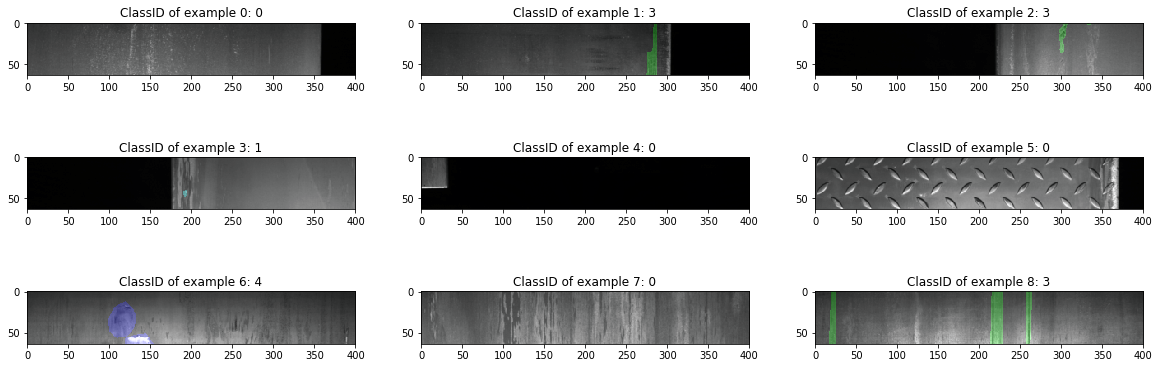

In [4]:
X_val, y_val, M_val = torch.load(INPUT_PATH), torch.load(LABEL_PATH), torch.load(MASK_PATH)

fig, ax = plt.subplots(3, 3, figsize=(20, 7))
start = 0
for i in range(start, start+9):
    img = np.transpose(X_val[i].numpy(), (1, 2, 0))*params['std'] + params['mean']
    mask = M_val[i].reshape(*params['size'])
    if y_val[i] > 0:
        img[mask == 1] = img[mask == 1] + params['colors'][y_val[i]-1]
    ax[(i-start)//3, (i-start)%3].set_title('ClassID of example {}: {}'.format(i, y_val[i]))
    ax[(i-start)//3, (i-start)%3].imshow(img)
plt.show()

### Model

In [5]:
### 4.1 Load architecture
net = models.squeezenet1_1(pretrained=True)
net.features = net.features[:10]
net.classifier[1] = nn.Conv2d(384, 1000, kernel_size = (1, 1), stride = (1, 1))
net.classifier = nn.Sequential(*net.classifier, nn.Flatten(), nn.Linear(1000, 5))
net = net.to(device)
net.load_state_dict(torch.load(MODEL_PATH))

y_pred, y_true, y_score = [], [], torch.Tensor([])
batch_size = 2

with torch.no_grad():
    net.eval()
    for n in tqdm(range(X_val.shape[0]//batch_size)):
        X, y = X_val[n*batch_size:(n+1)*batch_size].to(device), y_val[n*batch_size:(n+1)*batch_size].to(device).long()
        out = net(X)
        probs = out.detach().cpu()
        probs = nn.Softmax(dim=1)(out).detach().cpu()
        
        y_score = torch.cat([y_score, probs])
        y_pred = np.concatenate([y_pred, np.argmax(out.detach().cpu().numpy(), axis=1)])
        y_true = np.concatenate([y_true, y.cpu().numpy()])
        
y_score = y_score.numpy()
print('Accuracy: {:.4f}\tF1 Score: {:.4f}'.format(accuracy_score(y_true, y_pred), 
                                                  f1_score(y_true, y_pred, average='macro')))

100%|██████████████████████████████████████████████████████████████████████████████| 1214/1214 [00:21<00:00, 55.88it/s]

Accuracy: 0.9213	F1 Score: 0.8511


### Analysis TSNE

#### 1. Input

In [25]:
tsne_results = []
tsne = TSNE(perplexity=12, n_jobs=-1)
tsne_results.append(tsne.fit_transform(X_val.numpy().reshape(X_val.shape[0], -1)))

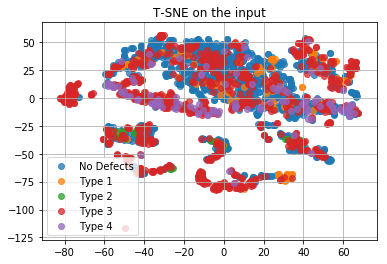

In [19]:
plt.scatter(tsne_results[0][:, 0][y_true == 0], tsne_results[0][:, 1][y_true == 0], alpha=0.75, label='No Defects')
for i in range(1, 5):
    plt.scatter(tsne_results[0][:, 0][y_true == i], tsne_results[0][:, 1][y_true == i], alpha=0.75, label='Type {}'.format(i))
plt.legend()
plt.title('T-SNE on the input')
plt.grid()
plt.show()

#### 2. Squeeze Fire layer

In [26]:
indexes = [3, 4, 6, 7, 9]
for i in indexes:
    tsne_X = torch.Tensor([])
    net.eval()
    for n in tqdm(range(X_val.shape[0]//batch_size)):
        X = X_val[n*batch_size:(n+1)*batch_size].to(device)
        out = net.features[i].squeeze(net.features[:i](X)).detach().cpu()
        tsne_X = torch.cat([tsne_X, out])
    tsne_X = tsne_X.numpy()
    #tsne = TSNE(perplexity=2, n_jobs=-1)
    X_val_tsne = tsne.fit_transform(tsne_X.reshape(tsne_X.shape[0], -1))
    tsne_results.append(X_val_tsne)

100%|██████████████████████████████████████████████████████████████████████████████| 1214/1214 [00:31<00:00, 38.88it/s]


#### 3. Last Layer

In [29]:
tsne_X = torch.Tensor([])
net.eval()
for n in range(X_val.shape[0]//batch_size):
    X = X_val[n*batch_size:(n+1)*batch_size].to(device)
    out = net.classifier[:1](net.features(X)).detach().cpu()
    tsne_X = torch.cat([tsne_X, out])
tsne_X = tsne_X.numpy()
#tsne = TSNE(perplexity=2, n_jobs=-1)
X_val_tsne = tsne.fit_transform(tsne_X.reshape(tsne_X.shape[0], -1))
tsne_results.append(X_val_tsne)

KeyboardInterrupt: 

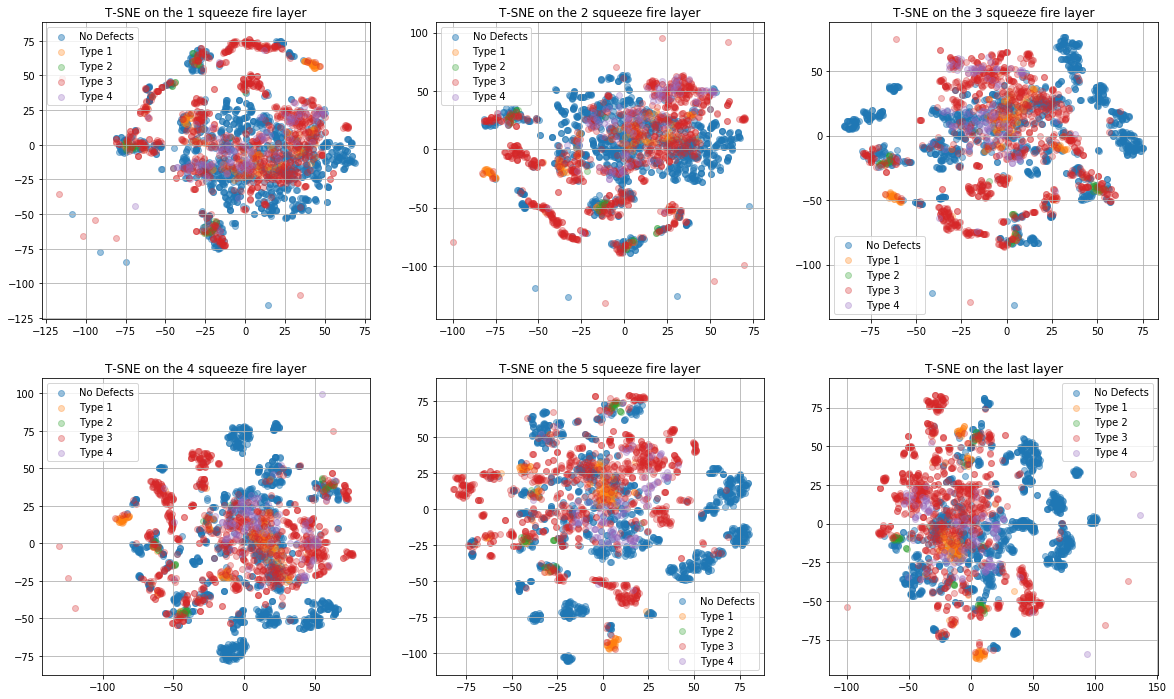

In [30]:
fig, ax = plt.subplots(2, 3, figsize=(20, 12))
for i in range(6):
    ax[i//3, i%3].scatter(tsne_results[i][:, 0][y_true == 0], 
                       tsne_results[i][:, 1][y_true == 0], 
                       alpha=0.45, label='No Defects')
    for j in range(1, 5):
        ax[i//3, i%3].scatter(tsne_results[i][:, 0][y_true == j], 
                              tsne_results[i][:, 1][y_true == j], 
                              alpha=0.30, label='Type {}'.format(j))
    ax[i//3, i%3].legend()
    if i < 5:
        ax[i//3, i%3].set_title('T-SNE on the {} squeeze fire layer'.format(i+1))
    else:
         ax[i//3, i%3].set_title('T-SNE on the last layer'.format(i))
    ax[i//3, i%3].grid()
plt.show()

### Maninfold capacity with T-SNE input

In [31]:
print('Squeeze input: {}'.format(3*64*400))
print('Squeeze 1st Fire: {}'.format(16*15*99))
print('Squeeze 2nd Fire: {}'.format(16*15*99))
print('Squeeze 3rd Fire: {}'.format(32*7*49))
print('Squeeze 4th Fire: {}'.format(32*7*49))
print('Squeeze 5th Fire: {}'.format(48*3*24))

Squeeze input: 76800
Squeeze 1st Fire: 23760
Squeeze 2nd Fire: 23760
Squeeze 3rd Fire: 10976
Squeeze 4th Fire: 10976
Squeeze 5th Fire: 3456


In [ ]:
# acc = []
# for i in tsne_results:
#     clf = LogisticRegression(C=0.1)
#     clf.fit(i, y_true)
#     acc.append(accuracy_score(clf.predict(i), y_true))
#     #print('Accuracy score: {:.4f}'.format(acc[-1]))
# reg = LinearRegression()
# reg.fit(np.arange(0, 7).reshape(-1, 1), np.array(acc).reshape(-1))
# y_pred = reg.predict(np.arange(-0.20, 7.20, step=0.05).reshape(-1, 1))
# plt.figure(figsize=(13, 4))
# plt.scatter(np.arange(0, 7), acc)
# plt.plot(np.arange(-0.20, 7.20, step=0.05), y_pred)
# plt.xlim([-0.05, 6.2])
# plt.grid()
# plt.xticks([i for i in range(7)], ['Input', '1st', '2nd', '3rd', 
#            '4th', '5th', 'Last'], rotation = 0)
# plt.ylabel('Accuracy of a Logistic Regression')
# plt.xlabel('Layer of application of T-SNE')
# plt.title('Capacity of Linear separability by each model CNN layer (T-SNE) output', y = 1.01)
# plt.show()

### Maninfold capacity with raw input

We should increase the number of iterations for the Logistic Regression for more reliable accuracy. But since we just need how the accuracy increases as we go deeper in the CNN, we do not need precise estimation of the accuracy as long we use the same method for each layer output

In [32]:
accs = []

pca =  PCA(0.925)
clf = LogisticRegression()
scaler = MinMaxScaler()

X = X_val.numpy().reshape(X_val.shape[0], -1)
X_train = pca.fit_transform(X[:1000])
X_test = pca.transform(X[1000:])
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
clf.fit(X_train, y_true[:1000])
accs.append(accuracy_score(clf.predict(X_test), y_true[1000:]))

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [33]:
indexes = [3, 4, 6, 7, 9]
for i in indexes:
    pca_X = torch.Tensor([])
    net.eval()
    for n in range(X_val.shape[0]//batch_size):
        X = X_val[n*batch_size:(n+1)*batch_size].to(device)
        out = net.features[i].squeeze(net.features[:i](X)).detach().cpu()
        pca_X = torch.cat([pca_X, out])
    X = pca_X.numpy().reshape(pca_X.shape[0], -1)
    X_train = pca.fit_transform(X[:1000])
    X_test = pca.transform(X[1000:])
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    clf.fit(X_train, y_true[:1000])
    accs.append(accuracy_score(clf.predict(X_test), y_true[1000:]))

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

In [34]:
pca_X = torch.Tensor([])
net.eval()
for n in range(X_val.shape[0]//batch_size):
    X = X_val[n*batch_size:(n+1)*batch_size].to(device)
    out = net.classifier[:1](net.features(X)).detach().cpu()
    pca_X = torch.cat([pca_X, out])
X = pca_X.numpy().reshape(pca_X.shape[0], -1)
X_train = pca.fit_transform(X[:1000])
X_test = pca.transform(X[1000:])
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
clf.fit(X_train, y_true[:1000])
accs.append(accuracy_score(clf.predict(X_test), y_true[1000:]))

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


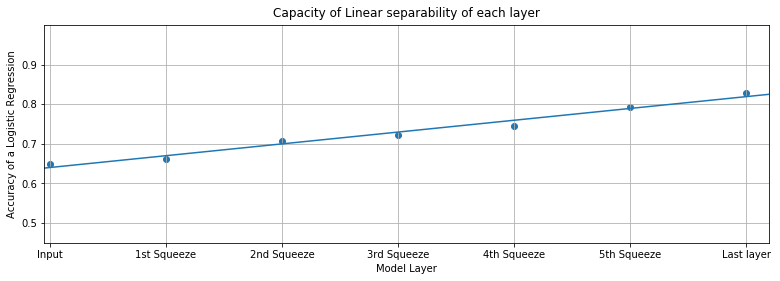

In [36]:
reg = LinearRegression()

reg.fit(np.arange(0, 7).reshape(-1, 1), np.array(accs).reshape(-1))
y_pred = reg.predict(np.arange(-0.20, 7.20, step=0.05).reshape(-1, 1))
plt.figure(figsize=(13, 4))
plt.scatter(np.arange(0, 7), accs, label='Raw output (m = {:.3f})'.format(reg.coef_[0]))
plt.plot(np.arange(-0.20, 7.20, step=0.05), y_pred)

# reg.fit(np.arange(0, 7).reshape(-1, 1), np.array(acc).reshape(-1))
# y_pred = reg.predict(np.arange(-0.20, 7.20, step=0.05).reshape(-1, 1))
# plt.scatter(np.arange(0, 7), acc, label='T-SNE output (m = {:.3f})'.format(reg.coef_[0]))
# plt.plot(np.arange(-0.20, 7.20, step=0.05), y_pred)

plt.xlim([-0.05, 6.2])
plt.ylim([0.45, 1])
plt.grid()
plt.xticks([i for i in range(7)], ['Input', '1st Squeeze', '2nd Squeeze', '3rd Squeeze', 
           '4th Squeeze', '5th Squeeze', 'Last layer'], rotation = 0)
plt.yticks([0.5, 0.6, 0.7, 0.8, 0.9], [0.5, 0.6, 0.7, 0.8, 0.9])
plt.ylabel('Accuracy of a Logistic Regression')
plt.xlabel('Model Layer')
#plt.legend(loc='upper left')
plt.title('Capacity of Linear separability of each layer', y = 1.01)
plt.show()

### Activation functions

In [7]:
modules = [
           list(net.children())[0][0], 
           list(net.children())[0][3].squeeze, list(net.children())[0][3].expand1x1, list(net.children())[0][3].expand3x3,
           list(net.children())[0][4].squeeze, list(net.children())[0][4].expand1x1, list(net.children())[0][4].expand3x3,
           list(net.children())[0][6].squeeze, list(net.children())[0][7].expand1x1, list(net.children())[0][6].expand3x3,
           list(net.children())[0][7].squeeze, list(net.children())[0][7].expand1x1, list(net.children())[0][7].expand3x3,
           list(net.children())[0][9].squeeze, list(net.children())[0][9].expand1x1, list(net.children())[0][9].expand3x3,
           list(net.children())[1][1]
          ]

module_name = ['Conv2d',
               'Squeeze', 'Exp_1x1', 'Exp_3x3',
               'Squeeze', 'Exp_1x1', 'Exp_3x3',
               'Squeeze', 'Exp_1x1', 'Exp_3x3',
               'Squeeze', 'Exp_1x1', 'Exp_3x3',
               'Squeeze', 'Exp_1x1', 'Exp_3x3',
               'Conv2d']

In [12]:
n = 0
means = []
stds = []


for n in tqdm(range(len(modules))):
    hook = c_explainers.SaveFeatures(modules[n])
    tmp_out = torch.Tensor([])
    for i in range(80):
        X = X_val[i*30:(i+1)*30].to(device)
        ### 2.Compute Loss and gradient
        _ = net(X) # Feed the input to the model
        tmp_out =  torch.cat([tmp_out, hook.features.detach().cpu()])
    means.append(tmp_out.mean().numpy())
    stds.append(tmp_out.mean(axis=(0, 2, 3)).numpy().std(axis=0))
means = np.array(means)
stds = np.array(stds)

In [8]:
# n = 0
# means = []
# stds = []


# for j in range(5):
#     tmp_mean, tmp_std = [], []
#     for n in tqdm(range(len(modules))):
#         hook = c_explainers.SaveFeatures(modules[n])
#         tmp_out = torch.Tensor([])
#         for i in range(80):
#             X = X_val[i*30:(i+1)*30].to(device)
#             ### 2.Compute Loss and gradient
#             _ = net(X) # Feed the input to the model
#             tmp_out =  torch.cat([tmp_out, hook.features.detach().cpu()])
#         tmp_mean.append(tmp_out.mean().numpy())
#         tmp_std.append(tmp_out.mean(axis=(0, 2, 3)).numpy().std(axis=0))
#     means.append(np.array(tmp_mean))
#     stds.append(np.array(tmp_std))

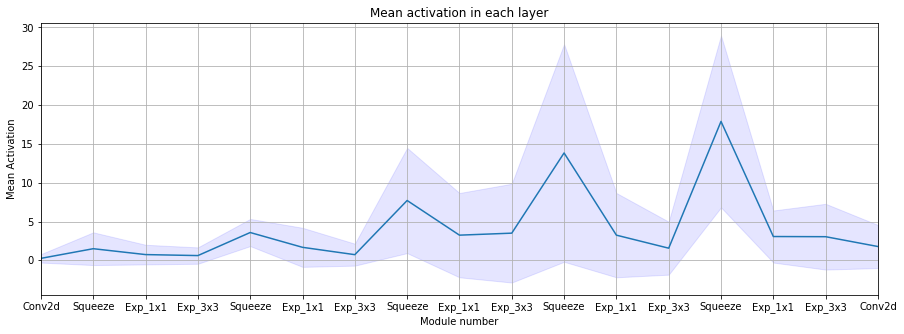

In [13]:
plt.figure(figsize=(15, 5))
plt.grid()

reg = LinearRegression()
reg.fit(np.arange(1, 18).reshape(-1, 1), np.array(means).reshape(-1))
y_pred = reg.predict(np.arange(0.80, 17.20, step=0.05).reshape(-1, 1))
#plt.plot(np.arange(0.80, 17.20, step=0.05), y_pred, '--', color='black', label='m = {:.3f}'.format(reg.coef_[0]))

plt.plot(np.arange(1, len(means)+1), means, label='No Defects')
plt.fill_between(np.arange(1, len(means)+1), (means-2*stds), (means+2*stds), color='b', alpha=.1)

plt.ylabel('Mean Activation')
plt.title("Mean activation in each layer")
plt.xlabel('Module number')
#plt.legend()
plt.xticks(np.arange(1, 18), module_name, rotation=0)
plt.xlim([1, 17])
plt.show()

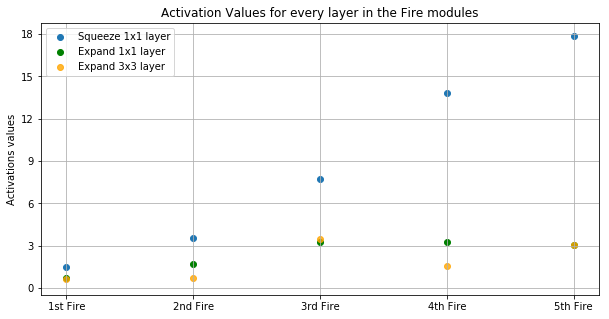

In [18]:
plt.figure(figsize=(10, 5))
ind = [1, 4, 7, 10, 13]
plt.scatter(np.arange(1, len(means[ind])+1), means[ind], label='Squeeze 1x1 layer')
# plt.fill_between(np.arange(1, len(mean_a[ind])+1), 
#                  (mean_a[ind]-2*std_a[ind]), 
#                  (mean_a[ind]+2*std_a[ind]), color='b', alpha=.03)
ind = [2, 5, 8, 11, 14]
plt.scatter(np.arange(1, len(means[ind])+1), means[ind], color='green', label='Expand 1x1 layer')
# plt.fill_between(np.arange(1, len(mean_a[ind])+1), 
#                  (mean_a[ind]-2*std_a[ind]), 
#                  (mean_a[ind]+2*std_a[ind]), color='green', alpha=.1)
ind = [3, 6, 9, 12, 15]
plt.scatter(np.arange(1, len(means[ind])+1), means[ind], color='orange', label='Expand 3x3 layer', alpha=0.8)
# plt.fill_between(np.arange(1, len(mean_a[ind])+1), 
#                  (mean_a[ind]-2*std_a[ind]), 
#                  (mean_a[ind]+2*std_a[ind]), color='orange', alpha=0.1)
plt.grid()
plt.legend(loc='upper left')
plt.xticks([1, 2, 3, 4, 5], ['1st Fire', '2nd Fire', '3rd Fire', '4th Fire', '5th Fire'])
plt.yticks([0, 3, 6, 9, 12, 15, 18])#, 12, 14, 16, 18, 20])
#plt.axhline(0, linestyle='--', color='black', linewidth=2)
plt.xlim([0.8, 5.2])
plt.ylabel('Activations values')
plt.title('Activation Values for every layer in the Fire modules')
plt.show()





### Weights

In [19]:
n = 0
means, stds = [], []

for mod in modules:
    mean = mod.weight.mean().detach().cpu().numpy()
    std = mod.weight.std().detach().cpu().numpy()
    means.append(mean)
    stds.append(std)
    
means, stds = np.array(means), np.array(stds)

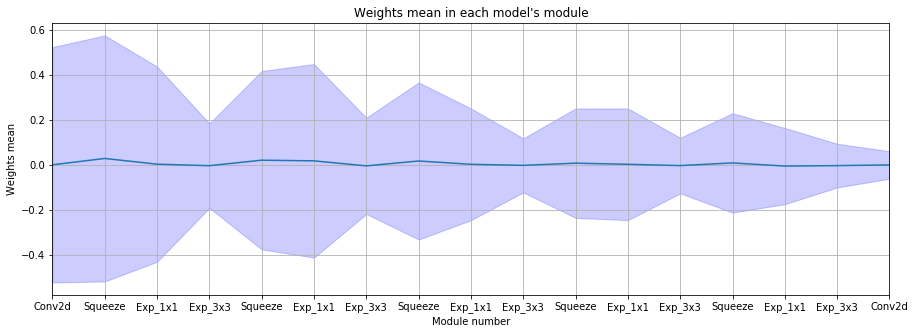

In [20]:
plt.figure(figsize=(15, 5))
plt.grid()
plt.plot(np.arange(1, len(means)+1), means)
plt.fill_between(np.arange(1, len(means)+1), (means-2*stds), (means+2*stds), color='b', alpha=.2)
plt.ylabel('Weights mean')
plt.title("Weights mean in each model's module")
plt.xlabel('Module number')
#plt.xticks(np.arange(1, 18))
plt.xlim([1, 17])
plt.xticks(np.arange(1, 18), module_name, rotation=0)
plt.show()

### Layer Saliency

In [59]:
net

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

In [91]:
x = X_val[5].unsqueeze(0).to(device)
ns = [(8, 8),
      (4, 4), (8, 8), (8, 8), 
      (4, 4), (8, 8), (8, 8),
      (8, 4), (16, 8), (16, 8),
      (8, 4), (16, 8), (16, 8),
      (8, 6), (16, 12), (16, 12)
     ]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


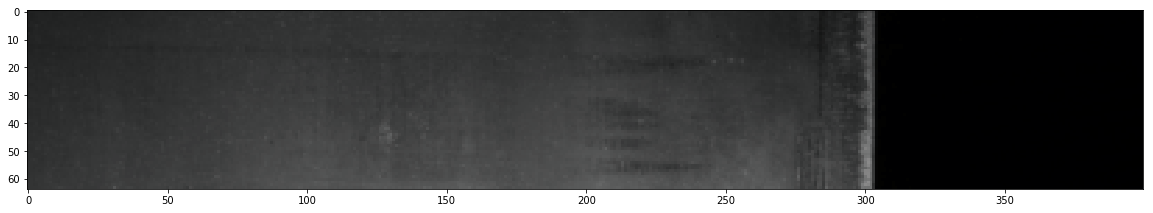

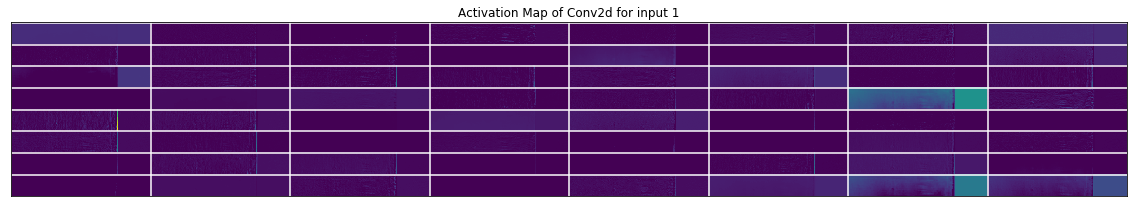

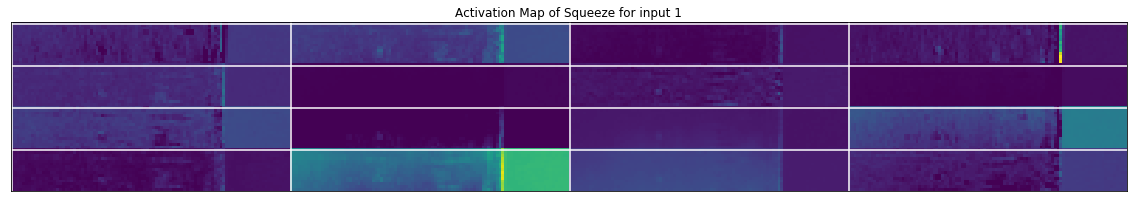

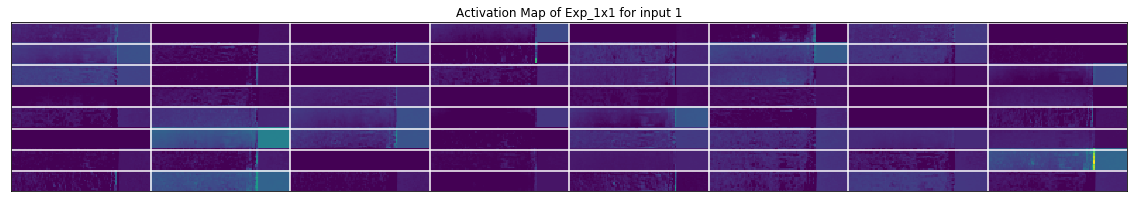

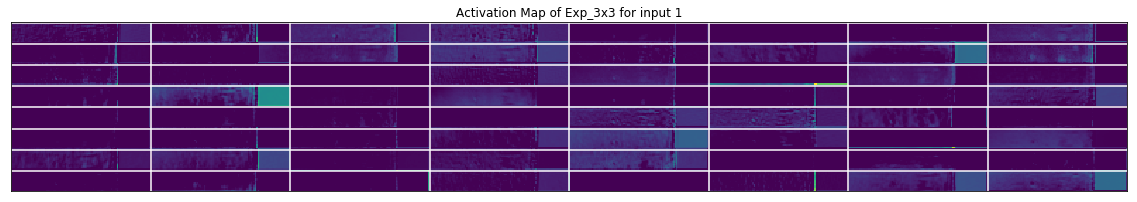

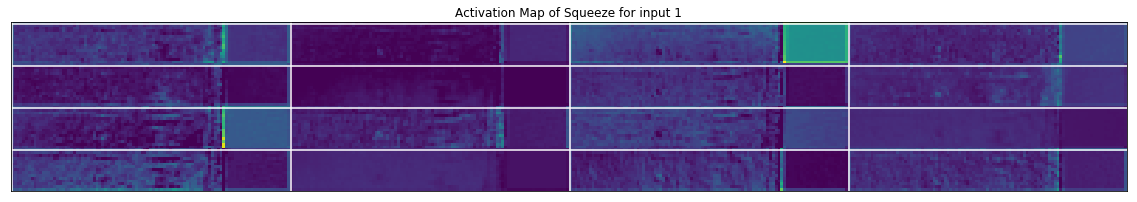

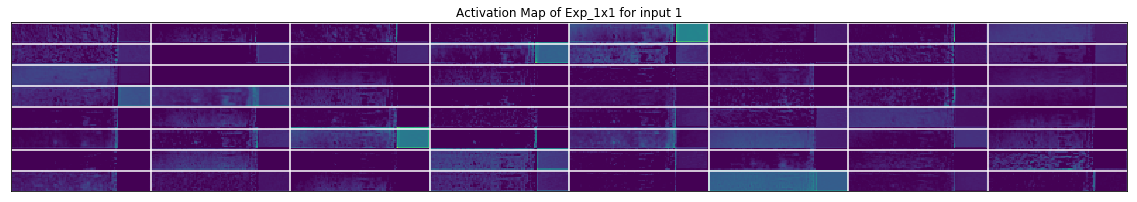

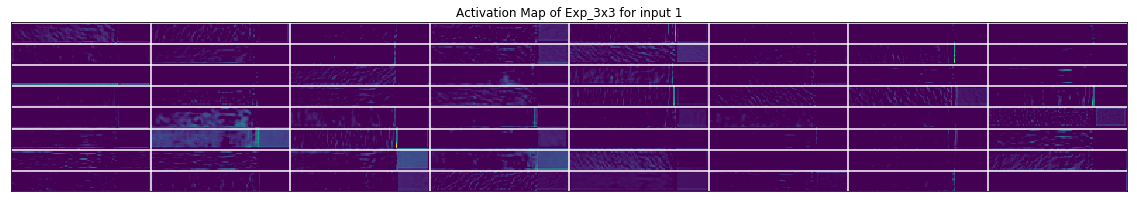

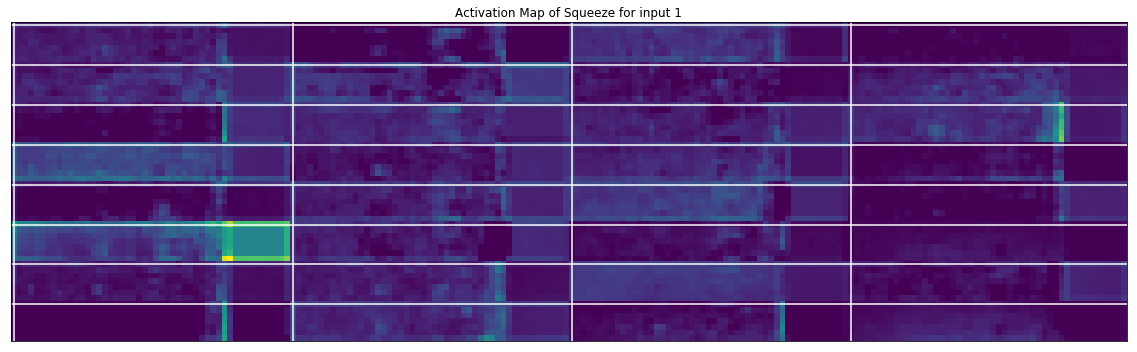

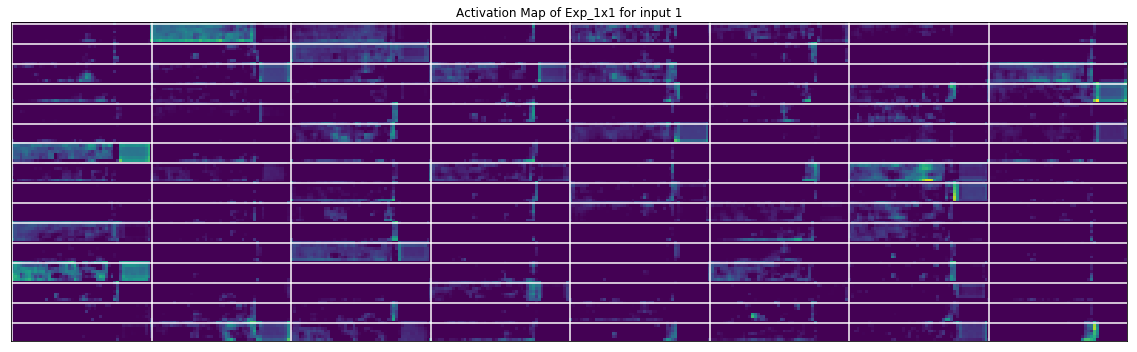

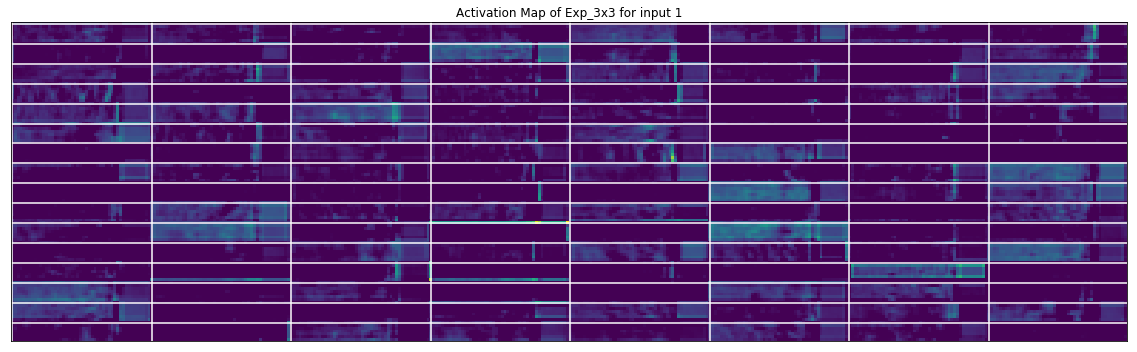

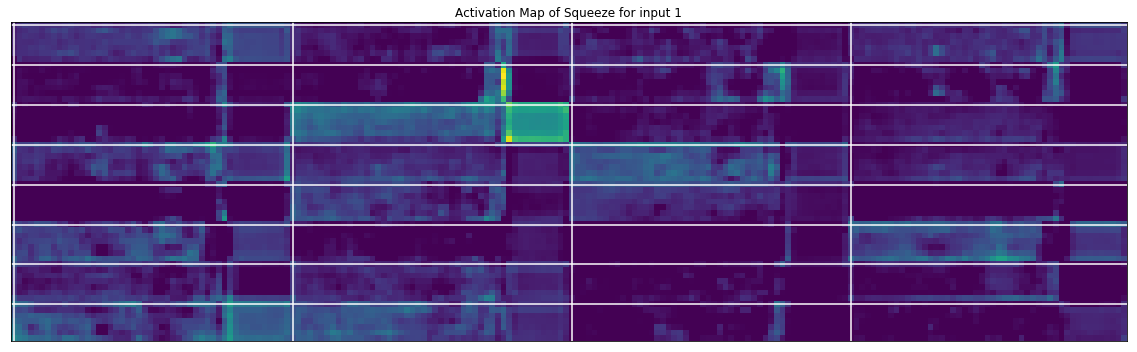

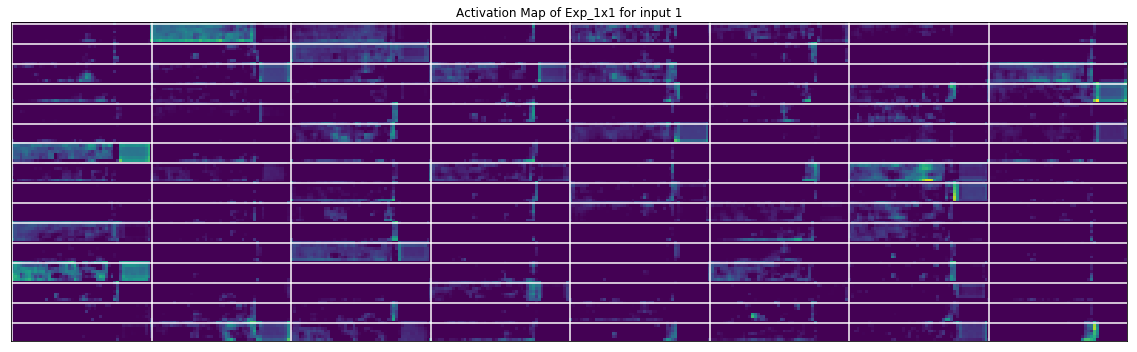

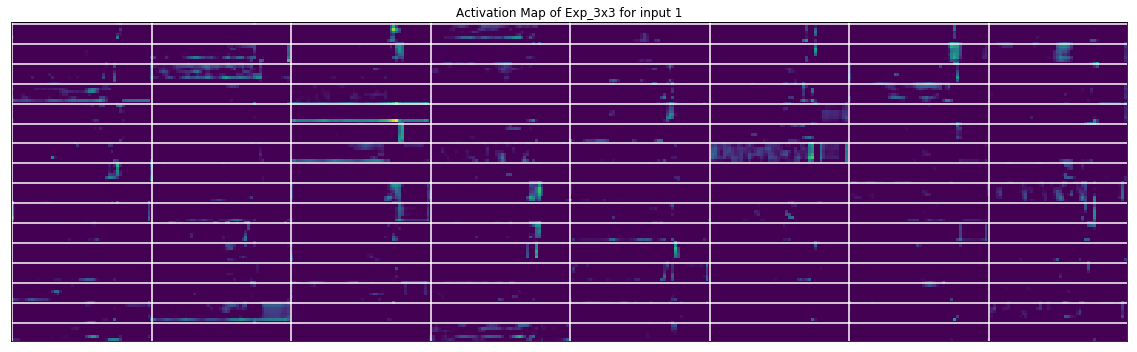

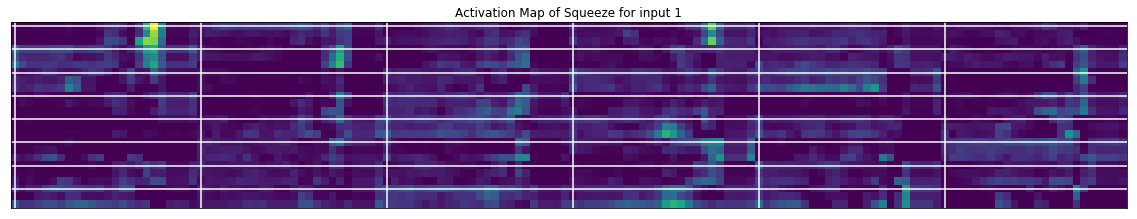

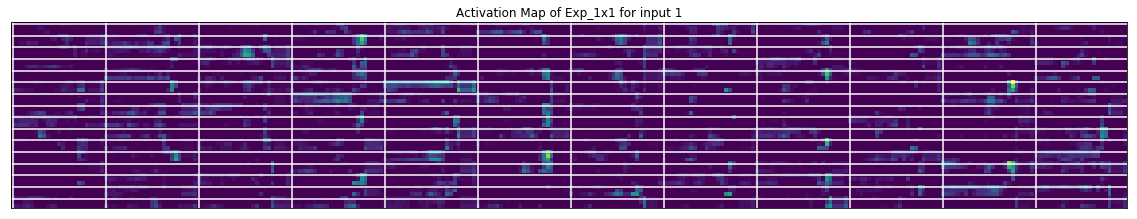

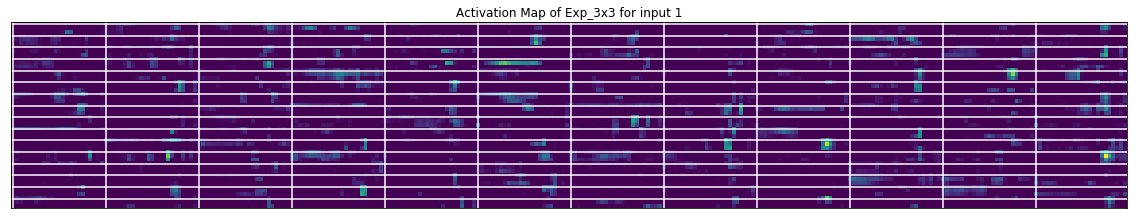

In [110]:
def visualize_layer_map(eg, module_number):
    x = X_val[eg].unsqueeze(0).to(device)
    k = module_number
    hook = c_explainers.SaveFeatures(modules[k])
    _ = net(x)    
    out =  hook.features.detach().cpu()
    n, m = ns[k][0], ns[k][1]
    X = np.zeros((out.shape[2]*n, out.shape[3]*m))
    for i in range(n):
        for j in range(m):
            X[i*out.shape[2]:(i+1)*out.shape[2], j*out.shape[3]:(j+1)*out.shape[3]] = out[0, i*m+j, :, :]

    plt.figure(figsize=(20, 15))
    plt.imshow(X)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.title('Activation Map of {} for input {}'.format(module_name[module_number], eg))
    for i in range(n):
        plt.axhline(i*out.shape[2], color='white')
    for j in range(m):
        plt.axvline(j*out.shape[3], color='white')
    plt.show()

eg = 1
plt.figure(figsize=(20, 15))
plt.imshow(np.transpose(X_val[eg].numpy(), (1,2,0))*params['std'] + params['mean'])
for i in range(16):
    visualize_layer_map(eg=eg, module_number=i)